In [1]:
import os
import yaml

import numpy as np
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import imagesize
import shutil

from joblib import Parallel, delayed

import wandb

In [2]:
api_wandb_key = 'cf1380c2be4499f36827184321c87d7da7942cc7'
wandb.login(key=api_wandb_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bucks2309 (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/misha/.netrc


True

In [3]:
FOLD = 0  # which fold to train
DIM = 640
MODEL = "yolov5x"
BATCH = 16
EPOCHS = 15
OPTMIZER = "SGD"

PROJECT = "happywhale-det-public"  # w&b in yolov5
NAME = f"{MODEL}-dim{DIM}-fold{FOLD}"  # w&b for yolov5

REBEL_PATH = '/home/misha/geoframework/'
DATA_PATH = '/media/storage3/data3T/happy_whale/hump_bbox'
ROOT_DIR = os.path.join(REBEL_PATH, 'models/rnd/happy_whale/data/crop')

IMAGE_DIR = os.path.join(DATA_PATH, "train")  # directory to save images
LABEL_DIR = os.path.join(DATA_PATH, "labels")  # directory to save labels

In [4]:
# !mkdir -p {IMAGE_DIR}
# !mkdir -p {LABEL_DIR}

In [4]:
df = pd.read_csv(f"{DATA_PATH}/train.csv")

# Train Data

df["image_id"] = df["Image"]
df["image_path"] = f"{IMAGE_DIR}/" + df.image_id
df["label_path"] = f"{LABEL_DIR}/" + df.image_id.str.replace("jpg", "txt")
df.head(2)

,Image,Id,image_id,image_path,label_path
0,00022e1a.jpg,w_e15442c,00022e1a.jpg,/media/storage3/data3T/happy_whale/hump_bbox/t...,/media/storage3/data3T/happy_whale/hump_bbox/l...
1,000466c4.jpg,w_1287fbc,000466c4.jpg,/media/storage3/data3T/happy_whale/hump_bbox/t...,/media/storage3/data3T/happy_whale/hump_bbox/l...


### Create BBox

In [5]:
from bbox.utils import coco2yolo, coco2voc, voc2yolo, yolo2voc
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [6]:
def point2bbox(points):
    points = np.array(points)
    points = points.astype('int') # str -> int
    points = points.reshape(-1, 2) # shape: (None, ) -> shape: (None, 2) => (x, y) format
    xmin, ymin, xmax, ymax = points[:, 0].min(), points[:, 1].min(), points[:, 0].max(), points[:, 1].max()
    return [[xmin, ymin, xmax, ymax]]

In [7]:
f = open('cropping.txt','rt').read()
id2point = {x.split(',')[0]:x.split(',')[1:] for x in f.split('\n')}
df['point'] = df['image_id'].map(id2point)
df = df[~df.point.isna()]
df['bbox'] = df.point.map(point2bbox)

### Get Image-Size

In [8]:
df = df.progress_apply(get_imgsize, axis=1)
display(df.head(2))

  0%|          | 0/1200 [00:00<?, ?it/s]

,Image,Id,image_id,image_path,label_path,point,bbox,width,height
1,000466c4.jpg,w_1287fbc,000466c4.jpg,/media/storage3/data3T/happy_whale/hump_bbox/t...,/media/storage3/data3T/happy_whale/hump_bbox/l...,"[233, 308, 243, 301, 508, 307, 578, 391, 561, ...","[[233, 301, 578, 434]]",1050,700
2,00087b01.jpg,w_da2efe0,00087b01.jpg,/media/storage3/data3T/happy_whale/hump_bbox/t...,/media/storage3/data3T/happy_whale/hump_bbox/l...,"[1, 63, 80, 8, 1010, 20, 1040, 28, 473, 365, 3...","[[1, 8, 1040, 366]]",1050,368


### Create Labels
1. We need to export our labels to YOLO format, with one *.txt file per image (if no objects in image, no *.txt file is required).
The *.txt file specifications are:

    - One row per object

    - Each row is class [x_center, y_center, width, height] format.

    - Box coordinates must be in normalized xywh format (from 0 - 1).
        - If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.

    - Class numbers are zero-indexed (start from 0).

    - Dataset bbox format is VOC-PASCAL hence [x_min, y_min, x_max, y_max].
So, we need to convert form VOC-PASCAL to YOLO format.

In [10]:
cnt = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width = row.width
    bboxes_voc = np.array(row.bbox).astype(np.float32).copy()
    num_bbox = len(bboxes_voc)
    names = ["whale"] * num_bbox
    labels = np.array([0] * num_bbox)[..., None].astype(str)
    ## Create Annotation(YOLO)
    with open(row.label_path, "w") as f:
        if num_bbox < 1:
            annot = ""
            f.write(annot)
            cnt += 1
            continue
        #         bboxes_voc  = coco2voc(bboxes_coco, image_height, image_width)
        bboxes_voc = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.image_id]] * len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)
print("Missing:", cnt)

  0%|          | 0/1200 [00:00<?, ?it/s]

Missing: 0


In [28]:
df['label_path'].values[0]

'/media/storage3/data3T/happy_whale/hump_bbox/labels/000466c4.txt'

### Create Folds
Number of samples aren't same in each fold which can create large variance in Cross-Validation.

In [11]:
kf = KFold(n_splits=6, random_state=42, shuffle=True)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    df.loc[val_idx, 'fold'] = fold
df.fold.value_counts()

2    200
5    200
1    200
4    200
0    200
3    200
Name: fold, dtype: int64

### Visualization

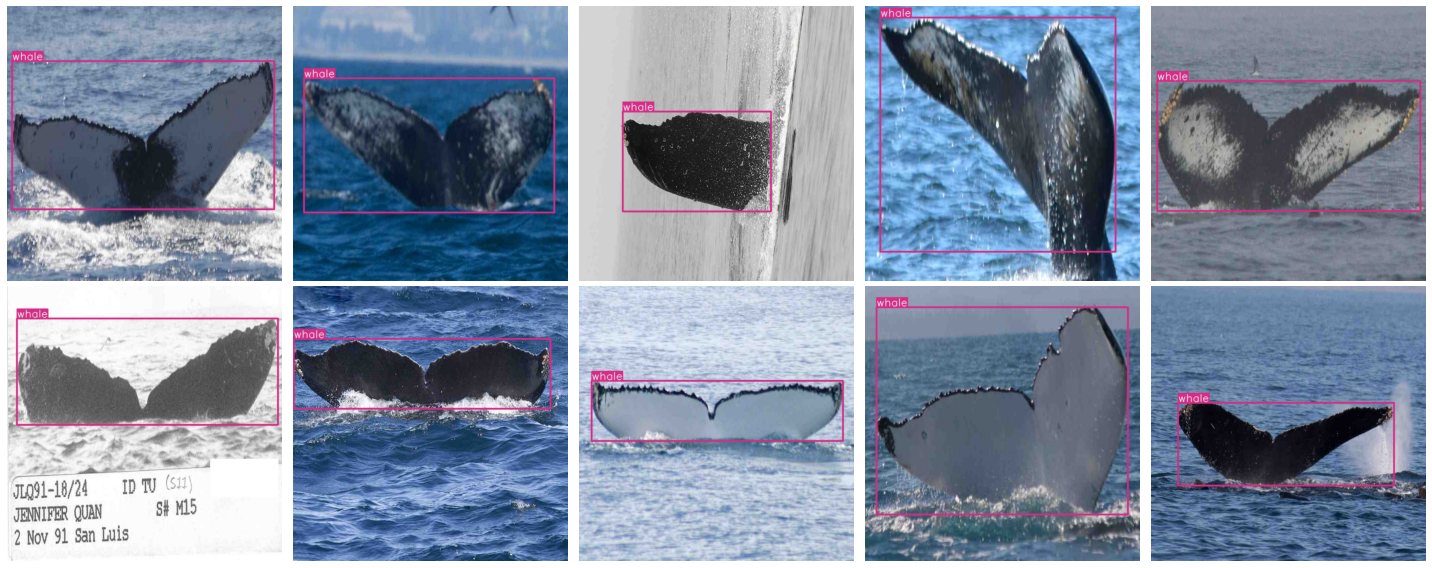

In [19]:
df2 = df.sample(100) # takes samples with bbox
y = 2
x = 5
plt.figure(figsize=(4 * x, 4 * y))
for idx in range(x*y):
    row = df2.iloc[idx]
    img           = load_image(row.image_path)
    img           = cv2.resize(img, (512, 512))
    image_height  = row.height
    image_width   = row.width
    with open(row.label_path) as f:
        annot = str2annot(f.read())
    bboxes_yolo = annot[...,1:]
    labels      = annot[..., 0].astype(int).tolist()
    names         = ['whale']*len(bboxes_yolo)
    plt.subplot(y, x, idx+1)
    plt.imshow(draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2))
    plt.axis('OFF')
plt.tight_layout()
plt.show()

### Dataset

In [12]:
train_files = []
val_files = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

(1000, 200)

### Configuration
The dataset config file requires

1. The dataset root directory path and relative paths to train / val / test image directories (or *.txt files with image paths)
2. The number of classes nc and
3. A list of class names:['cots']

In [28]:
cwd = DATA_PATH

with open(os.path.join(cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = cwd,
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['whale'],
    )

with open(os.path.join( cwd , 'happywhale.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'happywhale.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- whale
nc: 1
path: /media/storage3/data3T/happy_whale/hump_bbox
train: /media/storage3/data3T/happy_whale/hump_bbox/train.txt
val: /media/storage3/data3T/happy_whale/hump_bbox/val.txt



In [30]:
%%writefile /media/storage3/data3T/happy_whale/hump_bbox/hyp.yaml
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 30.0  # image rotation (+/- deg)
translate: 0.10  # image translation (+/- fraction)
scale: 0.80  # image scale (+/- gain)
shear: 10.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.5  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.75  # image mosaic (probability)
mixup: 0.0 # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

Writing /media/storage3/data3T/happy_whale/hump_bbox/hyp.yaml


### YOLOv5¶

In [15]:
%cd /media/storage3/data3T/happy_whale/hump_bbox
# !git clone https://github.com/ultralytics/yolov5 # clone

%cd yolov5
# %pip install -qr requirements.txt  # install

from yolov5 import utils
_ = utils.notebook_init()  # check

YOLOv5 🚀 v6.0-255-gca0a007 torch 1.9.1+cu102 CUDA:0 (NVIDIA GeForce GTX 1080, 8119MiB)


Setup complete ✅ (6 CPUs, 94.2 GB RAM, 170.8/197.7 GB disk)


### Training¶

In [23]:
# run script in tmux session
!python3 train.py --img {DIM}\
--batch {BATCH}\
--epochs {EPOCHS}\
--optimizer {OPTMIZER}\
--data /media/storage3/data3T/happy_whale/hump_bbox/happywhale.yaml\
--hyp /media/storage3/data3T/happy_whale/hump_bbox/hyp.yaml\
--weights {MODEL}.pt\
--project {PROJECT} --name {NAME}\
--exist-ok
# python3 train.py --img 640 --batch 16 --epochs 15 --optimizer 'SGD' --data /media/storage3/data3T/happy_whale/hump_bbox/happywhale.yaml --hyp /media/storage3/data3T/happy_whale/hump_bbox/hyp.yaml --weights "yolov5x".pt --project "happywhale-det-public" --name 'yolov5x-dim640-fold0' --exist-ok


Traceback (most recent call last):
  File "train.py", line 26, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'
